<h1> Imports

In [3]:
! pip install datasets
! pip install transformers
! pip install torchinfo
! pip install torchtext
! pip install colored

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 16.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 74.4 MB/s eta 0:00

In [33]:
import torch
from datasets import load_dataset
from tqdm import tqdm
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from termcolor import colored
from collections import Counter

<h1> Loading and Exploring Datasets

In [103]:
silicone_swda = load_dataset('silicone', 'swda')

  0%|          | 0/3 [00:00<?, ?it/s]

In [109]:
silicone_mrda = load_dataset('silicone', 'mrda')

Generating train split:   0%|          | 0/83943 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/15470 [00:00<?, ? examples/s]

Dataset silicone downloaded and prepared to /root/.cache/huggingface/datasets/silicone/mrda/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [110]:
silicone_mrda

DatasetDict({
    train: Dataset({
        features: ['Utterance_ID', 'Dialogue_Act', 'Channel_ID', 'Speaker', 'Dialogue_ID', 'Utterance', 'Label', 'Idx'],
        num_rows: 83943
    })
    validation: Dataset({
        features: ['Utterance_ID', 'Dialogue_Act', 'Channel_ID', 'Speaker', 'Dialogue_ID', 'Utterance', 'Label', 'Idx'],
        num_rows: 9815
    })
    test: Dataset({
        features: ['Utterance_ID', 'Dialogue_Act', 'Channel_ID', 'Speaker', 'Dialogue_ID', 'Utterance', 'Label', 'Idx'],
        num_rows: 15470
    })
})

In [111]:
print(Counter(silicone_mrda['train']['Label']) )

Counter({0: 50896, 1: 11516, 2: 11205, 3: 5448, 4: 4878})


In [112]:
print(Counter(silicone_mrda['test']['Label']) )

Counter({0: 8864, 1: 2246, 2: 1961, 3: 1317, 4: 1082})


In [116]:
silicone_mrda['train'][5]

{'Utterance_ID': 'Bed002-c0_0018289_0022839',
 'Dialogue_Act': 's',
 'Channel_ID': 'Bed002-c0',
 'Speaker': 'me011',
 'Dialogue_ID': 'Bed002',
 'Utterance': "and you should be able to see which one - which one you're on by uh watching the little bars change .",
 'Label': 0,
 'Idx': 5}

In [117]:
#Compute max len
max([len(ut) for ut in silicone_mrda['train']['Utterance']])

438

In [118]:
#Compute aerage len
sum([len(ut) for ut in silicone_mrda['train']['Utterance']])/len([len(ut) for ut in silicone['train']['Utterance']])

16.335437761196378

<h1> Importing Pretrained Embeddings

In [31]:
from torchtext.vocab import GloVe, vocab, FastText

# pretrained_vectors = GloVe(name="6B", dim='50')
pretrained_vectors = FastText(language='en')

In [32]:
pretrained_vocab = vocab(pretrained_vectors.stoi)
#Insert unknown token
unk_token = "<unk>"
unk_index = 0
pretrained_vocab.insert_token("<unk>",unk_index)
#Insert padding token
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<pad>", pad_index)

#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([2519371, 300])

<h1> Data Preprocessing

<h2> Tokenize and pad

In [34]:
# tok = TreebankWordTokenizer()
tok = TweetTokenizer()

In [35]:
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=20):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

def tokenize_all(entries, vocab_stoi):
  res = {}
  res['Utterance'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=50) for entry in entries['Utterance']]
  res['Label'] = entries['Label']
  return res

In [119]:
silicone_mrda['train'] = silicone_mrda['train'].map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

Map:   0%|          | 0/83943 [00:00<?, ? examples/s]

In [120]:
print(silicone_mrda['train']['Utterance'][:2])

[[29, 3140, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [5397, 0, 16, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [121]:
silicone_mrda['validation'] = silicone_mrda['validation'].map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
silicone_mrda['test'] = silicone_mrda['test'].map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/15470 [00:00<?, ? examples/s]

<h1> DataLoaders

In [122]:
from torch.utils.data import Dataset
import numpy as np

class UtteranceDataset(Dataset):
    def __init__(self, data, args):
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "Utterance": np.array(self.data[idx]['Utterance']),
          "Label": np.array(self.data[idx]['Label'])
      }
      return item

In [123]:
# Create DataLoader
from torch.utils.data import DataLoader

args = {'bsize': 64}

train_loader = DataLoader(UtteranceDataset(silicone_mrda['train'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(UtteranceDataset(silicone_mrda['validation'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(UtteranceDataset(silicone_mrda['test'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

<h1> MLP

<h2> Defining the Model

In [124]:
class BasicMLP(torch.nn.Module):
  def __init__(self, D_in, H, D_out, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(BasicMLP, self).__init__()

        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_layer = torch.nn.Linear(H, H, bias = True)
        self.classification_layer = torch.nn.Linear(H, D_out, bias = True)
        self.softmax = torch.nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # we don't use it here but it's a good thing to keep in mind
        # self.dropout = nn.Dropout(p=0.2)
      
  def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.ebd(x)
        x  = x.mean(1) #Pourquoi?
        h = torch.relu(self.hidden_layer(x))
        # h = self.dropout(h)
        h = self.classification_layer(h)
        logits = self.softmax(h)
        
        return logits

<h2> Instanciating the Model

In [125]:
sizes = next(iter(train_loader))['Utterance'].size()
batchsize = sizes[0]
inputdim  = sizes[1]
print(batchsize, inputdim)

64 50


In [126]:
hiddendim = 300 # dimension of the pretrained vector
outputdim = len(set(silicone_mrda['train']['Label']))
print(hiddendim, outputdim)

300 5


In [127]:
#Instantiate the model
utterance_model = BasicMLP(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

utterance_model

BasicMLP(
  (ebd): Embedding(2519370, 300)
  (hidden_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

In [128]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
utterance_model.to(device)

DEVICE =  CPU


BasicMLP(
  (ebd): Embedding(2519370, 300)
  (hidden_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

In [129]:
from torchinfo import summary
print(summary(utterance_model.to('cpu'), (batchsize, inputdim), dtypes=['torch.IntTensor'], device='cpu', verbose=2))
utterance_model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
BasicMLP                                 [64, 5]                   --
├─Embedding: 1-1                         [64, 50, 300]             (755,811,000)
│    └─weight                                                      └─755,811,000
├─Linear: 1-2                            [64, 300]                 90,300
│    └─weight                                                      ├─90,000
│    └─bias                                                        └─300
├─Linear: 1-3                            [64, 5]                   1,505
│    └─weight                                                      ├─1,500
│    └─bias                                                        └─5
├─Softmax: 1-4                           [64, 5]                   --
Total params: 755,902,805
Trainable params: 91,805
Non-trainable params: 755,811,000
Total mult-adds (G): 48.38
Input size (MB): 0.01
Forward/backward pass size (MB): 7.84
Params si

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


BasicMLP(
  (ebd): Embedding(2519370, 300)
  (hidden_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

<h2> Training Loop

In [130]:
def train(model, optimizer, ep, args):
  # set the model into a training mode 
  model.train()

  # Empty lists for loss and accuracy
  loss_it = list()
  acc_it = list()

  # start the loop over all the training batches
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total = train_loader.__len__()):

    batch = {'Utterance': batch['Utterance'].to('cpu'), 'Label': batch['Label'].to('cpu')}

    # Reset optimizer
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['Utterance'])

    # Computing weights according to inverse frequency of labels
    b_counter = Counter(batch['Label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['Label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to('cpu')

    # Loss
    loss_function = torch.nn.CrossEntropyLoss(weight=b_weights)
    loss = loss_function(logits, batch['Label'])

    #Computing backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # Adding loss value to current iteration list
    loss_it.append(loss.item())

    # Get predicted class
    _, tag_seq = torch.max(logits, 1)

    # Computing accuracy
    correct = (tag_seq.flatten() == batch['Label'].flatten()).float().sum()
    acc = correct / batch['Label'].flatten().size(0)
    acc_it.append(acc.item())

  # Losses and accuracies average for the epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

<h1> Inference Loop

In [134]:
def inference(target, loader, model):
  #set model into evaluation mode
  model.eval()

  #Empty lists for loss, accuracy, f1-score, predicted and true values
  loss_it = list()
  acc_it = list()
  f1_it = list()
  preds = list()
  trues = list()

  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):

    with torch.no_grad():

      batch = {'Utterance': batch['Utterance'].to('cpu'), 'Label': batch['Label'].to('cpu')}

      # apply the model
      logits = model(batch['Utterance'])

      # Loss
      loss_function = torch.nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['Label'])
      loss_it.append(loss.item())

      # Get predicted class
      _, tag_seq = torch.max(logits, 1)

      # Accuracy
      correct = (tag_seq.flatten() == batch['Label'].flatten()).float().sum()
      acc = correct / batch['Label'].flatten().size(0)
      acc_it.append(acc.item())

      #Preds and trues
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['Label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it


In [135]:
import torch.optim as optim

def run_epochs(model, args):
  # Adam optimizer
  optimizer = optim.Adam(model.parameters(), lr = args["lr"])

  # Validation losses
  val_ep_losses = list()

  for ep in range(args['max_eps']):
    train(model, optimizer, ep, args)
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)

    # append the validation losses
    val_ep_losses.append(val_loss_it_avg)

  return val_ep_losses

In [136]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 10, 'lr': 0.001, 'num_class': outputdim})

# Instantiate model
# model = TweetModel(pretrained_embeddings, args['num_class'], args, dimension=50, freeze_embeddings = True )
utterance_model = BasicMLP(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(utterance_model, args)

Epoch 0:: 100%|██████████| 1311/1311 [00:43<00:00, 30.29it/s]

Epoch 0/10 : Training : (loss 1.3030922377409597) (acc 0.5702111937452327)



validation:: 100%|██████████| 153/153 [00:12<00:00, 12.56it/s]

validation : (loss 1.2558436759936265) (acc 0.6858660130718954)



Epoch 1:: 100%|██████████| 1311/1311 [00:43<00:00, 30.07it/s]

Epoch 1/10 : Training : (loss 1.1366491518249773) (acc 0.745876239511823)



validation:: 100%|██████████| 153/153 [00:03<00:00, 39.47it/s]

validation : (loss 1.2110622723897297) (acc 0.7066993464052288)



Epoch 2:: 100%|██████████| 1311/1311 [00:46<00:00, 28.39it/s]

Epoch 2/10 : Training : (loss 1.1003695510435796) (acc 0.7807494279176201)



validation:: 100%|██████████| 153/153 [00:03<00:00, 41.67it/s]

validation : (loss 1.1833181389017042) (acc 0.7305964052287581)



Epoch 3:: 100%|██████████| 1311/1311 [00:38<00:00, 33.82it/s]

Epoch 3/10 : Training : (loss 1.088118294511107) (acc 0.7943602212051869)



validation:: 100%|██████████| 153/153 [00:03<00:00, 40.28it/s]

validation : (loss 1.1311562240513322) (acc 0.7665441176470589)



Epoch 4:: 100%|██████████| 1311/1311 [00:36<00:00, 35.79it/s]

Epoch 4/10 : Training : (loss 1.078532596565584) (acc 0.8065884820747521)



validation:: 100%|██████████| 153/153 [00:05<00:00, 26.38it/s]

validation : (loss 1.1270064115524292) (acc 0.7697099673202614)



Epoch 5:: 100%|██████████| 1311/1311 [00:37<00:00, 35.22it/s]

Epoch 5/10 : Training : (loss 1.0755271478339428) (acc 0.8087576277650649)



validation:: 100%|██████████| 153/153 [00:05<00:00, 28.88it/s]

validation : (loss 1.1175053119659424) (acc 0.7779820261437909)



Epoch 6:: 100%|██████████| 1311/1311 [00:37<00:00, 35.07it/s]

Epoch 6/10 : Training : (loss 1.0715352949706949) (acc 0.8135249809305873)



validation:: 100%|██████████| 153/153 [00:03<00:00, 40.62it/s]

validation : (loss 1.1222227367700315) (acc 0.7778799019607843)



Epoch 7:: 100%|██████████| 1311/1311 [00:40<00:00, 32.40it/s]

Epoch 7/10 : Training : (loss 1.0670460155681287) (acc 0.8203780511060259)



validation:: 100%|██████████| 153/153 [00:03<00:00, 41.06it/s]

validation : (loss 1.1117347112668106) (acc 0.8022875816993464)



Epoch 8:: 100%|██████████| 1311/1311 [00:39<00:00, 33.47it/s]

Epoch 8/10 : Training : (loss 1.067133923689888) (acc 0.8174699656750573)



validation:: 100%|██████████| 153/153 [00:03<00:00, 40.94it/s]

validation : (loss 1.1363230316467534) (acc 0.7650122549019608)



Epoch 9:: 100%|██████████| 1311/1311 [00:38<00:00, 34.01it/s]

Epoch 9/10 : Training : (loss 1.0642231236333433) (acc 0.8182565789473685)



validation:: 100%|██████████| 153/153 [00:04<00:00, 36.78it/s]

validation : (loss 1.1103180194991866) (acc 0.7904411764705882)


<h2> Validation loss

In [137]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))
  # let's directly show the plot when calling this function
  plt.show()

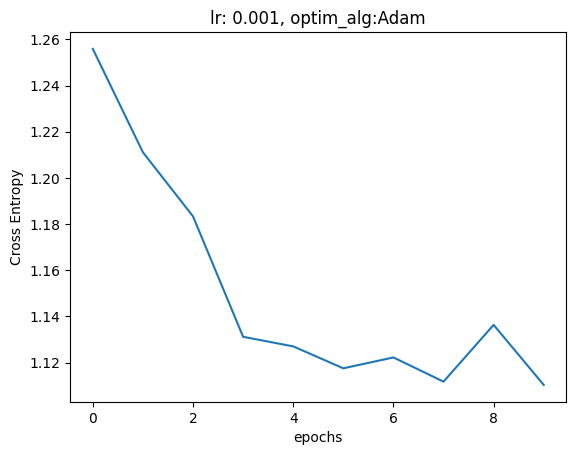

In [138]:
plot_loss(loss_list_val)

<h2> Evaluate Model

In [139]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, utterance_model)

test:: 100%|██████████| 241/241 [00:11<00:00, 21.35it/s]

test : (loss 1.076215797440145) (acc 0.8287733402489627)


In [143]:
# let's look at the first ten predictions
for t, p in zip(trues[:30], preds[:30]):
  correct = colored('Correct', 'green') if t == p else colored('Mistake', 'red')
  print('true', t, 'predicted', p, correct)

true 0 predicted 0 Correct
true 0 predicted 0 Correct
true 0 predicted 0 Correct
true 3 predicted 3 Correct
true 0 predicted 0 Correct
true 1 predicted 1 Correct
true 0 predicted 0 Correct
true 0 predicted 2 Mistake
true 1 predicted 1 Correct
true 1 predicted 1 Correct
true 0 predicted 0 Correct
true 0 predicted 0 Correct
true 0 predicted 2 Mistake
true 1 predicted 1 Correct
true 0 predicted 0 Correct
true 2 predicted 2 Correct
true 1 predicted 1 Correct
true 0 predicted 0 Correct
true 0 predicted 3 Mistake
true 1 predicted 1 Correct
true 0 predicted 2 Mistake
true 1 predicted 1 Correct
true 1 predicted 2 Mistake
true 0 predicted 0 Correct
true 0 predicted 0 Correct
true 0 predicted 0 Correct
true 1 predicted 1 Correct
true 1 predicted 1 Correct
true 0 predicted 0 Correct
true 3 predicted 3 Correct


<h2> Classification Report

In [145]:
! pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=b4a495ed8a817d70880d72369f9859723ff7e80ccd34468b45ab21ac39676f88
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


In [148]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten()))

              precision    recall  f1-score   support

           0       0.97      0.80      0.87      8837
           1       0.84      0.82      0.83      2240
           2       0.54      0.96      0.69      1951
           3       0.76      0.76      0.76      1315
           4       0.90      0.94      0.92      1081

    accuracy                           0.83     15424
   macro avg       0.80      0.86      0.81     15424
weighted avg       0.87      0.83      0.84     15424



<h2> Confusion Matrix

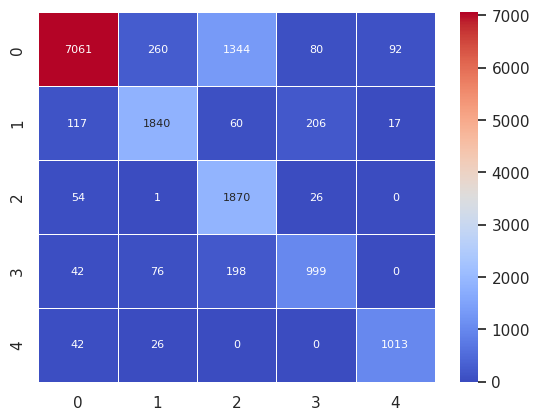

In [150]:
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

<h1> Bi-LSTM

<h1> Transformers